# COVID 19 XRAY IMAGE CLASSIFICATION

## Necessary libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import itertools
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive


## Common functions

In [12]:
def plot_loss(history):
  epochs = list(range(1, len(history.history['loss']) + 1))
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  df = pd.DataFrame({
      'Epoch': epochs * 2,
      'Loss': loss + val_loss,
      'Type': ['Training Loss'] * len(loss) + ['Validation Loss'] * len(val_loss)
  })

  fig = px.line(
      df,
      x='Epoch',
      y='Loss',
      color='Type',
      labels={'Epoch': 'Epoch', 'Loss': 'Loss'},
      title='Training and Validation Loss'
  )
  fig.update_layout(legend_title_text='Loss Type')
  fig.update_traces(mode='lines', hoverinfo='all', line=dict(width=2))

  fig.show()

In [13]:
import pandas as pd
import plotly.express as px

def plot_accuracy(history):
    epochs = list(range(1, len(history.history['accuracy']) + 1))
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    df = pd.DataFrame({
        'Epoch': epochs * 2,
        'Accuracy': accuracy + val_accuracy,
        'Type': ['Training Accuracy'] * len(accuracy) + ['Validation Accuracy'] * len(val_accuracy)
    })

    fig = px.line(
        df,
        x='Epoch',
        y='Accuracy',
        color='Type',
        labels={'Epoch': 'Epoch', 'Accuracy': 'Accuracy'},
        title='Training and Validation Accuracy'
    )
    fig.update_layout(legend_title_text='Metric Type')
    fig.update_traces(mode='lines', hoverinfo='all', line=dict(width=2))

    fig.show()


In [14]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model):
  y_pred = model.predict(X_test)
  y_pred_classes = np.round(y_pred)

  # Compute the confusion matrix
  cm = confusion_matrix(Y_test, y_pred_classes)

  # Plot the confusion matrix
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def print_metrics_val(model):
  print("Metrics for validation set:")
  Y_pred_in = model.predict(X_test)
  Y_pred = (Y_pred_in > 0.5).astype(int)

  accuracy = accuracy_score(Y_test, Y_pred)
  precision = precision_score(Y_test, Y_pred)  # Use 'micro', 'macro', or 'weighted' for multi-class
  recall = recall_score(Y_test, Y_pred)
  f1 = f1_score(Y_test, Y_pred)

  print(f"Accuracy: {accuracy}")
  print(f"Precision: {precision}")
  print(f"Recall: {recall}")
  print(f"F1 Score: {f1}")


In [20]:
from sklearn.metrics import roc_curve, auc
import plotly.graph_objs as go

def plot_roc_curve_with_plotly(model, X_test, Y_test):
    y_pred_probs = model.predict(X_test).ravel()
    fpr, tpr, thresholds = roc_curve(Y_test, y_pred_probs)

    roc_auc = auc(fpr, tpr)

    trace1 = go.Scatter(x=fpr, y=tpr,
                        mode='lines',
                        line=dict(color='darkorange', width=2),
                        name=f'ROC curve (AUC = {roc_auc:.2f})')

    trace2 = go.Scatter(x=[0, 1], y=[0, 1],
                        mode='lines',
                        line=dict(color='navy', width=2, dash='dash'),
                        name='Random')

    layout = go.Layout(title='Receiver Operating Characteristic',
                       xaxis=dict(title='False Positive Rate'),
                       yaxis=dict(title='True Positive Rate'),
                       showlegend=True)

    fig = go.Figure(data=[trace1, trace2], layout=layout)

    fig.show()

## Class wheighting

In [67]:
drive.mount('/content/drive')

def load_images_and_labels(paths, labels):
    images = []
    image_labels = []

    for i, path in enumerate(paths):
        for filename in os.listdir(path):
            img_path = os.path.join(path, filename)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
            img = tf.keras.preprocessing.image.img_to_array(img)
            images.append(img)
            image_labels.append(labels[i])

    return np.array(images), np.array(image_labels)

# These paths may change for each tester
dataset_paths = ['/content/drive/My Drive/xrays/HEALTHY',
                 '/content/drive/My Drive/xrays/COVID'
        ]

labels = [0,1]

images, image_labels = load_images_and_labels(dataset_paths, labels)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
images = images / 255.0
label_to_index = dict((name, index) for index, name in enumerate(labels))
image_labels = np.array([label_to_index[label] for label in image_labels])


In [69]:
labels = [0,1]

def convert_to_rgb(image_paths, labels):
    images = []
    image_labels = []

    for path, label in zip(image_paths, labels):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path) and not filename.startswith('.'):
                img = load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                img = img_to_array(img)
                img = np.repeat(img, 3, axis=2)
                images.append(img)
                image_labels.append(label)

    return np.array(images), np.array(image_labels)

images, image_labels = convert_to_rgb(dataset_paths,labels)


In [70]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(
    images, image_labels, test_size=test_size, random_state=42
)
print(Y_train)
print(Y_test)

[1 1 1 ... 1 1 0]
[0 1 0 ... 0 1 1]


In [71]:
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
class_weights_dict = dict(enumerate(class_weights))


In [72]:
# Early stoping technique
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model1 = Model(inputs=base_model.input, outputs=x)
model1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history1 = model1.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

model1.save('vgg19_class_weight_model.h5')

with open('vgg19_class_weight_history.json', 'w') as f:
    json.dump(history1.history, f)

Epoch 1/30
105/105 [==============================] - 9s 79ms/step - loss: 0.8737 - accuracy: 0.8794 - val_loss: 0.0987 - val_accuracy: 0.9593
Epoch 2/30
105/105 [==============================] - 7s 70ms/step - loss: 0.0822 - accuracy: 0.9677 - val_loss: 0.0581 - val_accuracy: 0.9821
Epoch 3/30
105/105 [==============================] - 7s 69ms/step - loss: 0.0446 - accuracy: 0.9844 - val_loss: 0.0737 - val_accuracy: 0.9665
Epoch 4/30
105/105 [==============================] - 7s 69ms/step - loss: 0.0277 - accuracy: 0.9886 - val_loss: 0.0598 - val_accuracy: 0.9749
Epoch 5/30
105/105 [==============================] - 7s 70ms/step - loss: 0.0256 - accuracy: 0.9910 - val_loss: 0.1242 - val_accuracy: 0.9677
Epoch 6/30
105/105 [==============================] - 7s 70ms/step - loss: 0.0333 - accuracy: 0.9871 - val_loss: 0.0526 - val_accuracy: 0.9785
Epoch 7/30
105/105 [==============================] - 7s 69ms/step - loss: 0.0192 - accuracy: 0.9907 - val_loss: 0.0904 - val_accuracy: 0.9725

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



In [73]:
from google.colab import files

files.download('vgg19_class_weight_history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [74]:
!cp vgg19_class_weight_model.h5 "/content/drive/My Drive/"

In [75]:
!cp vgg19_class_weight_history.json "/content/drive/My Drive/"

In [77]:
plot_loss(history=history1)

In [79]:
plot_accuracy(history1)


In [81]:
print_metrics_val(model=model1)

Metrics for validation set:
33/33 [==============================] - 2s 47ms/step
Accuracy: 0.9741626794258373
Precision: 0.9828269484808454
Recall: 0.9815303430079155
F1 Score: 0.9821782178217822


33/33 [==============================] - 2s 47ms/step


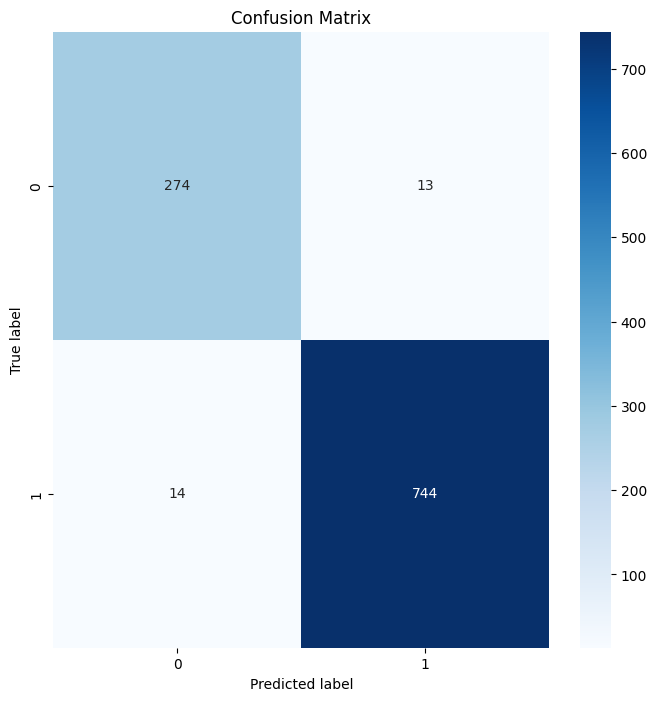

In [83]:
plot_confusion_matrix(model1)

In [85]:
plot_roc_curve_with_plotly(model1, X_test, Y_test)


33/33 [==============================] - 2s 47ms/step


## Data Augmentation

### Create dataset (run only once)

In [ ]:
# Data augmentation
def augment_images(image_directory, save_directory, augmentations_per_image=5):
    os.makedirs(save_directory, exist_ok=True)

    image_paths = [os.path.join(image_directory, f) for f in os.listdir(image_directory)
                   if os.path.isfile(os.path.join(image_directory, f)) and not f.startswith('.')]

    for img_path in image_paths:
        img = load_img(img_path)
        img_array = img_to_array(img)
        img_array = img_array.reshape((1,) + img_array.shape)

        i = 0
        for batch in data_augmentation.flow(img_array, batch_size=1,
                                            save_to_dir=save_directory, save_prefix='aug', save_format='jpeg'):
            i += 1
            if i >= augmentations_per_image:
                break


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


augmentations_per_image = 2

augment_images(
    image_directory= '/content/drive/My Drive/xrays/HEALTHY',
    save_directory='/content/drive/My Drive/AUGMENTED_HEALTHY',
    augmentations_per_image=augmentations_per_image
)

### VGG with augmented

In [2]:
original_healthy_path = '/content/drive/My Drive/xrays/HEALTHY'
augmented_healthy_path = '/content/drive/My Drive/AUGMENTED_HEALTHY'
sick_lungs_path = '/content/drive/My Drive/xrays/COVID'


def load_images_and_labels(image_paths, labels):
    images = []
    image_labels = []

    for path, label in zip(image_paths, labels):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path):
                img = load_img(file_path, target_size=(224, 224))
                img = img_to_array(img)
                img /= 255.0
                images.append(img)
                image_labels.append(label)

    return np.array(images), np.array(image_labels)

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

labels = [0, 0, 1]

images, image_labels = load_images_and_labels(
    [original_healthy_path, augmented_healthy_path, sick_lungs_path],
    labels
)
images = images / 255.0
label_to_index = dict((name, index) for index, name in enumerate(labels))
image_labels = np.array([label_to_index[label] for label in image_labels])


In [4]:
image_paths = [original_healthy_path,augmented_healthy_path,sick_lungs_path]
def convert_to_rgb(image_paths, labels):
    images = []
    image_labels = []

    for path, label in zip(image_paths, labels):
        for filename in os.listdir(path):
            file_path = os.path.join(path, filename)
            if os.path.isfile(file_path) and not filename.startswith('.'):
                img = load_img(file_path, color_mode='grayscale', target_size=(224, 224))
                img = img_to_array(img)
                img = np.repeat(img, 3, axis=2)
                images.append(img)
                image_labels.append(label)

    return np.array(images), np.array(image_labels)

images, image_labels = convert_to_rgb(image_paths,labels)

In [5]:
from sklearn.model_selection import train_test_split

test_size = 0.2

X_train, X_test, Y_train, Y_test = train_test_split(
    images, image_labels, test_size=test_size, random_state=42
)
print(Y_train)
print(Y_test)

[1 0 0 ... 1 0 1]
[1 0 1 ... 1 1 1]


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[:-4]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model2 = Model(inputs=base_model.input, outputs=x)
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history2 = model2.fit(
    X_train, Y_train,
    batch_size=32,
    epochs=30,
    validation_split=0.2,
    callbacks=[early_stopping]
)


Epoch 1/30
152/152 [==============================] - 18s 89ms/step - loss: 0.2924 - accuracy: 0.9440 - val_loss: 0.0625 - val_accuracy: 0.9818
Epoch 2/30
152/152 [==============================] - 11s 70ms/step - loss: 0.0544 - accuracy: 0.9808 - val_loss: 0.0495 - val_accuracy: 0.9860
Epoch 3/30
152/152 [==============================] - 10s 69ms/step - loss: 0.0528 - accuracy: 0.9845 - val_loss: 0.0544 - val_accuracy: 0.9802
Epoch 4/30
152/152 [==============================] - 11s 69ms/step - loss: 0.0276 - accuracy: 0.9911 - val_loss: 0.0642 - val_accuracy: 0.9835
Epoch 5/30
152/152 [==============================] - 11s 69ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.1368 - val_accuracy: 0.9769
Epoch 6/30
152/152 [==============================] - 11s 69ms/step - loss: 0.0248 - accuracy: 0.9928 - val_loss: 0.0524 - val_accuracy: 0.9901
Epoch 7/30
152/152 [==============================] - 11s 70ms/step - loss: 0.0169 - accuracy: 0.9938 - val_loss: 0.0550 - val_accuracy:

In [8]:
model2.save('vgg19_augmented_model.h5')
with open('vgg19_augmented_history.json', 'w') as f:
    json.dump(history2.history, f)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [9]:
!cp vgg19_augmented_model.h5 "/content/drive/My Drive/"

In [11]:
!cp vgg19_augmented_history.json "/content/drive/My Drive/"

In [15]:
plot_accuracy(history2)


In [16]:
plot_loss(history2)

In [19]:
print_metrics_val(model=model2)

Metrics for validation set:
48/48 [==============================] - 3s 55ms/step
Accuracy: 0.9775280898876404
Precision: 0.9681933842239185
Recall: 0.9883116883116884
F1 Score: 0.9781491002570695


48/48 [==============================] - 2s 47ms/step


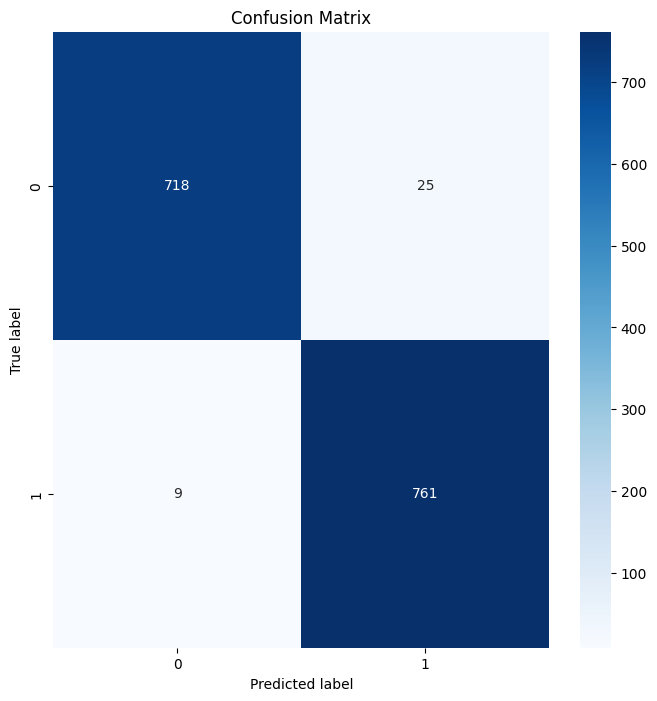

In [22]:
plot_confusion_matrix(model2)

In [21]:
plot_roc_curve_with_plotly(model2, X_test, Y_test)

48/48 [==============================] - 2s 47ms/step
